<!-- Customize the font and markdown size -->
# Custom RL Algorithm with ev2gym gym environment🚗🚗🔋🔋📉
---

This Notebook provides a simple example of how to develop your own custom RL environment using the OpenAI Gym interface. We will use the **simple configuration of ev2gym** for the power *setpoint tracking problem*. We will then train a simple DQN agent to solve the environment.


**Learning Objectives:**
- Familiarize with the OpenAI Gym interface
- Develop a DQN agent for a simple environment

### 1. Creating the Environment 🚗

- ev2gym simulates a Charge Point Operator (CPO) controlling a **fixed number of charging stations** scattered in a city where EVs that arrive and depart.

- The goal of the CPO is to **minimize the difference between the power setpoint and the actual power** consumed by the charging stations.

 - The CPO can control the current(**A**) of each port of each charging station. The current is limited by the **maximum current**(**I**) of the charging station and the **maximum current**(**I**) of the port.



In [1]:
#Install the required packages
!pip install ev2gym

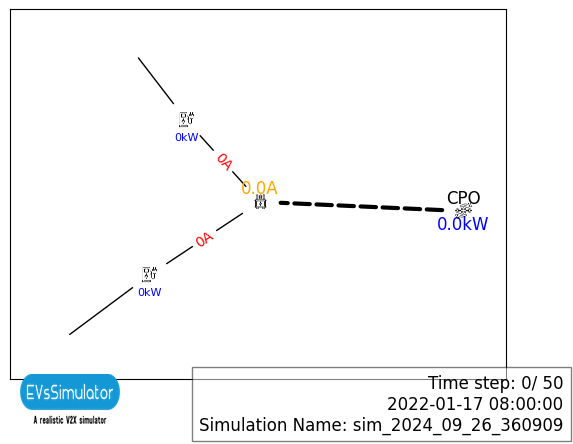

In [2]:
import numpy as np
from ev2gym.models.ev2gym_env import EV2Gym

# 使用绝对路径配置文件
config_file = "C:\\Users\\River\\Desktop\\EV2Gym-main\\EV2Gym-main\\ev2gym\\example_config_files\\simplePST.yaml"

# 创建环境
env = EV2Gym(config_file,
             render_mode=True,
             seed=42,
             save_plots=False,
             save_replay=False)


#### 1.1 Action Space
The ***action space*** is a vector of size **N** (total number of ports) where each element is a continuous value between **-1** and **1** representing the **percentage of the maximum current** that the CPO wants to set for each 
port.

Values from -1 to 0 represent discharging the EVs, 0 means no current, and values from 0 to 1 represent charging the EVs.


**Discretization** is necessary because the action space is continuous and the DQN algorithm requires a discrete action space

In [3]:
# Example discretization of the state space
def example_discretize_action(action):
    if action == 0:
        return [0, 0]
    elif action == 1:
        return [0.5, 0]
    elif action == 2:
        return [1, 0]
    elif action == 3:
        return [0, 0.5]
    elif action == 4:
        return [0, 1]
    elif action == 5:
        return [0.5, 0.5]    
    else:
        raise ValueError("Invalid action: ", action)
    
n_actions = 6 

#### Your turn: **Create the discretized action space**
- It should be a list of two ints from [0 to 1]
- Use the same format as in the example above
- Do not forget to put the number of different actions in the **n_actions** variable

In [4]:
# Example: Make your own discretization of the action space
def discretize_action(action):
   
    if action == 0:
        return [0, 0]
    elif action == 1:
        return [0.5, 0]
    elif action == 2:
        return [1, 0]
    elif action == 3:
        return [0, 0.5]
    elif action == 4:
        return [0, 1]
    elif action == 5:
        return [0.5, 0.5]    
    else:
        raise ValueError("Invalid action: ", action)
    
n_actions = 6 

#### 1.2 State Space

The ***state space*** provides information about the current state of the environment. Normaly the user has the option to configure the state space. In this case, the state space is a vector of 14 variables where each element is a continuous value representing the following information:

- **[0-3]**: Time of the simulation
- **[4]**: Power Setpoint for the current timestep
- **[5]**: Total power potential of the charging stations, if EVs were charging at maximum current
- **[6-10]**: Information about EV at Charging Station 1
- **[11-14]**: Information about EV at Charging Station 2



In [5]:
#Get the initial state
env.reset()

(array([0., 0., 0., 0., 0., 0., 0., 0., 0.]), {})

#### 1.3 Reward Function

The ***reward function*** returns a reward value based on action that led to the current state of the environment. The reward function is defined by the user and it is one of the most important parts of the environment. The reward function should be designed to guide the agent to the desired behavior.

! The reward function is **called in every step** of the simultion.


Example reward function that penalizes the squared difference between the minimum of the power setpoint or the power potential and the actual power consumed by the charging stations.

$$
R(s_t,a_t,s_{t+1}) = - (min(P^{setpoint}, P^{potential}) - P^{actual})^2
$$

In [6]:
def example_reward_function(env,*args):
    # This reward function is the squared tracking error that uses the minimum of the power setpoints and the charge power potential
    # The reward is negative
    
    reward = - (min(env.power_setpoints[env.current_step-1], env.charge_power_potential[env.current_step-1]) -
        env.current_power_usage[env.current_step-1])**2
    
    return reward

#### Your turn: **Create the reward function**
- It should be a function that returns a float
- Use the same format as in the example above

- Available variables:
    - **env.current_step**: current timestep
    - **env.power_setpoints[]**: list of power setpoints for each timestep
    - **env.charge_power_potential[]**: list of total power potential for each timestep
    - **env.current_power_usage[]**: list of actual power charged at each timestep
    - ...

In [7]:
def reward_function(env,*args):
    # This reward function is the squared tracking error that uses the minimum of the power setpoints and the charge power potential
    # The reward is negative
    
    reward = - (min(env.power_setpoints[env.current_step-1], env.charge_power_potential[env.current_step-1]) -
        env.current_power_usage[env.current_step-1])**2
    
    return reward

## 2. Setting Up the DQN Agent 🤖
---

Here, we will develop a simple DQN agent to solve the environment.

Code based on the [DQN tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) from the PyTorch website.

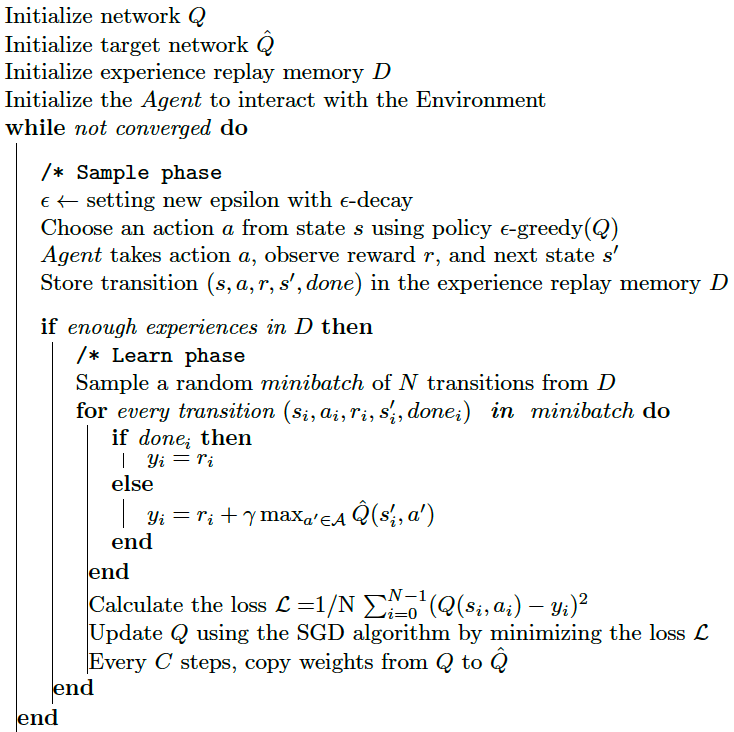

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import random
import math
from collections import namedtuple, deque
from itertools import count

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

##### Neural Network Architecture

In RL, the neural network is usually a simple fully connected network with 2 hidden layers. The input is the state space and the output is the action space.

In [10]:
class Example_Qnetwork(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(Example_Qnetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

##### Design Your own Q-network

- Based on the example above, design your own Q-network 
    - Number of hidden layers
    - Number of neurons in each layer
    - Activation functions

In [11]:
class Qnetwork(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(Qnetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

#### Training

In an RL training process the agent interacts with the environment and learns from the experience. The agent's experience is stored in a replay memory. The agent samples a batch of experiences from the replay memory and learns from it. The goal is to maximize the expected reward.


In [12]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TAU = 0.005
LR = 1e-4


# Get the number of state observations
state,_ = env.reset()
n_observations = len(state)

policy_net = Qnetwork(n_observations, n_actions).to(device)
target_net = Qnetwork(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0


#### Exploration

The agent uses an $\epsilon$-greedy policy to explore the environment. The $\epsilon$-greedy policy selects a random action with probability $\epsilon$ and the action with the highest Q-value with probability $1-\epsilon$.


In [13]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randint(0,n_actions-1)]], device=device, dtype=torch.long)

#### Update Neural Network

The neural network is updated using the DQN loss function:

$$
L = \frac{1}{N}\sum_i (y_i - Q(s_i, a_i))^2
$$

where $y_i$ is the target value and $Q(s_i, a_i)$ is the predicted value.

The target value is calculated as follows:

$$
y_i = r_i + \gamma \max_{a'} Q(s_{i+1}, a')

$$

where $r_i$ is the reward, $\gamma$ is the discount factor, and $s_{i+1}$ is the next state.

#### Target Network

The target network is used to calculate the target value. The weights of the target network are updated with the weights of the Q-network every $C$ steps.






In [14]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

#### Main Training Loop

In [15]:
episode_rewards = []
episode_stats = []

env.set_reward_function(reward_function)

if torch.cuda.is_available():
    num_episodes = 200
else:
    num_episodes = 50
    
    

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    episode_reward = 0
    for t in count():
        action = select_action(state)      
        
        observation, reward, done, truncated, stats = env.step(discretize_action(action.item()))
        episode_reward += reward
        reward = torch.tensor([reward], device=device)        

        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_rewards.append(episode_reward)
            episode_stats.append(stats)
            print(f'Iteration {i_episode}/{num_episodes}: Episode reward: {episode_reward} ')
            # episode_durations.append(t + 1)
            # plot_durations()
            
            break

print('Complete')
# plot_durations(show_result=True)
# plt.ioff()
# plt.show()


TypeError: sum(): argument 'input' (position 1) must be Tensor, not list

Plot the total rewards per episode to see how the agent improved during training.

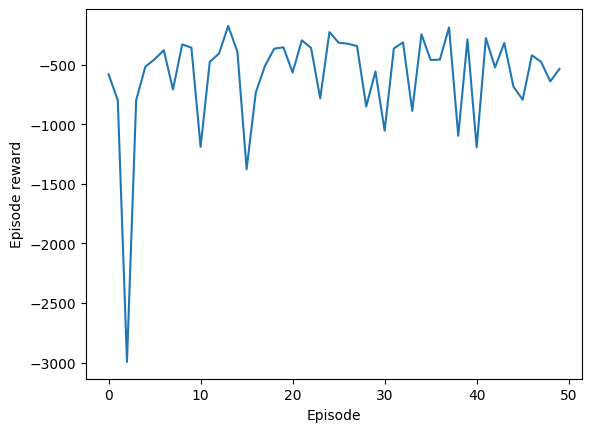

In [16]:
#Plot the rewards
from matplotlib import pyplot as plt

plt.plot(episode_rewards)
plt.ylabel('Episode reward')
plt.xlabel('Episode')
plt.show()


Plot other metrics from the info dictionary returned by the environment. For example, the number of times the agent charged or discharged the EVs.

array([<Axes: >, <Axes: >], dtype=object)

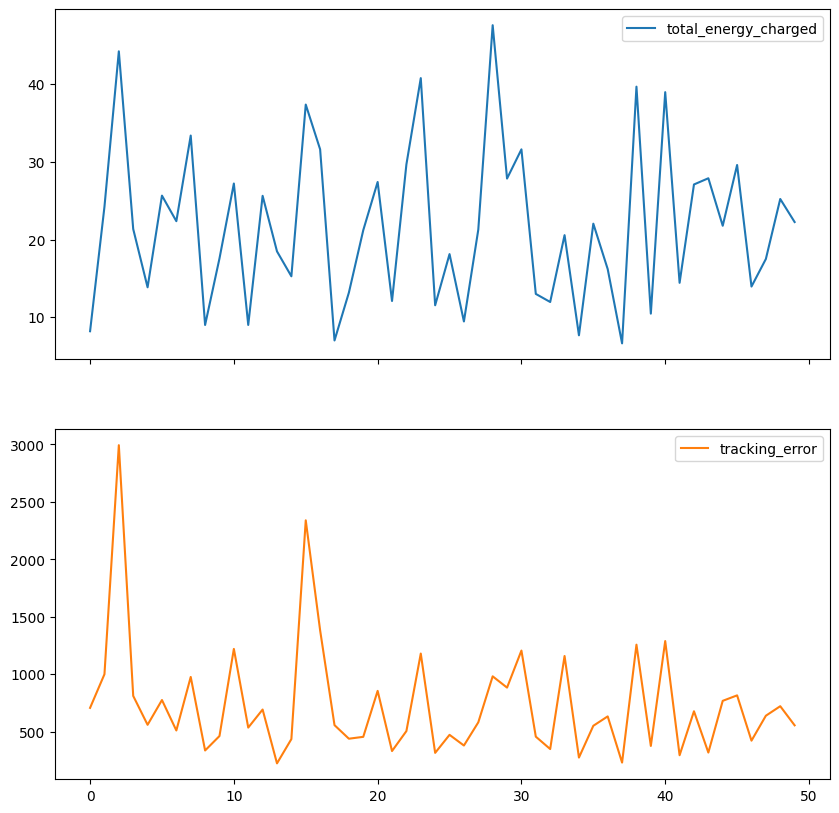

In [17]:
#plot episode stats
import pandas as pd
episode_stats = pd.DataFrame(episode_stats)
#Select only the columns we want to plot
episode_stats = episode_stats[['total_energy_charged','tracking_error']]

#plot
episode_stats.plot(subplots=True, figsize=(10,10))
